In [154]:
import sys
from pyspark import SparkContext
import time
from pyspark.sql.functions import countDistinct
import timeit
import gc
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql import Row
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
from pyspark.sql.functions import *
import pyspark.sql.functions as f

sns.set(color_codes=True)

read the data table "machine events":
    1. timestamp
    2. machine ID
    3. event type
    4. platform ID
    5. capacity: CPU
    6. capacity: memory
Description of the table:
    'event_type'    
    1. Contains information about the machines that went offline and reconnected during the period that the data covers

In [49]:
#if sc:
#    sc.stop()
sc = SparkContext("local[1]")
sc.setLogLevel("ERROR")

## Q1: What is the distribution of the machines according to their CPU capacity?

In [106]:
machine_events = sc.textFile('../../datasets/machine_events/*.gz')
machine_events_RDD = machine_events.map(lambda line: line.split(","))
print(machine_events_RDD.take(1))
machine_events_RDD = machine_events_RDD.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), tokens[3], tokens[4], tokens[5]))
machine_events_RDD_filtered = machine_events_RDD.map(lambda elem: (elem[0], elem[1], elem[2], elem[3], elem[4], elem[5])).filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1)).sortByKey(1, 1)

[['0', '5', '0', 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.2493']]


In [107]:
#creating the dataframe out of rdd for faster processing
## and data cleaning
sqlContext = SQLContext(sc)
machine_events_df = sqlContext.createDataFrame(machine_events_RDD_filtered, schema=['timestamp', 'machineID', 'eventtype', 'platformID', 'CPU', 'memory'])
machine_events_df = machine_events_df.filter(machine_events_df.CPU!='')
machine_events_df = machine_events_df.select(machine_events_df.timestamp, machine_events_df.machineID, machine_events_df.eventtype, machine_events_df.platformID, machine_events_df.CPU.cast('float'), machine_events_df.memory.cast('float'))

In [142]:
##get the distributions of CPUs to a single dataframe
cpu_all = machine_events_df.dropDuplicates(['machineID']).select('CPU')
##convert the dataframe back to the rdd, 
##map all values to the pairs (cpu, 1), 
##reduce by finding the quantity of each distinct value of cpu
##collect as a list of lists
distinct_count = cpu_all.rdd.map(lambda x: (float(x[0]), 1)).reduceByKey(lambda x, y: x+y).map(lambda x: list([x[0], x[1]])).collect()

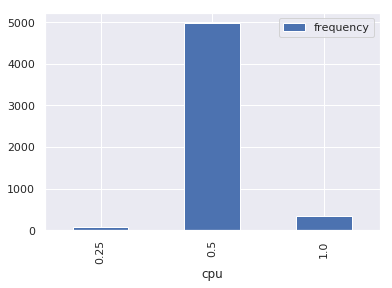

In [152]:
##plot the collected value to freq matrix
d = pd.DataFrame(distinct_count)
d.columns=['cpu', 'frequency']
d.sort_values(['cpu'], ascending=True).set_index('cpu').plot(kind='bar')

In [219]:
distinct_count

,CPU,count
0,0.25,87
1,0.50,4979
2,1.00,346


In [220]:
87+4979+346

5412

### Q1: Some extra observations

In [153]:
## Get Statistics of the total distribution of 
#'timestamps', 'CPU', 'memory' over time
statistics_timestamp = machine_events_df.describe('timestamp')
print(statistics_timestamp.show())
statistics_CPU = machine_events_df.describe('CPU')
print(statistics_CPU.show())
statistics_timestamp = machine_events_df.describe('memory')
print(statistics_timestamp.show())

+-------+--------------------+
|summary|           timestamp|
+-------+--------------------+
|  count|               25271|
|   mean|1.301830958638486...|
| stddev|7.215246485293291E11|
|    min|           779231019|
|    max|       2506135493517|
+-------+--------------------+

None
+-------+-------------------+
|summary|                CPU|
+-------+-------------------+
|  count|              25271|
|   mean| 0.5245043726010051|
| stddev|0.12051419436483145|
|    min|               0.25|
|    max|                1.0|
+-------+-------------------+

None
+-------+-------------------+
|summary|             memory|
+-------+-------------------+
|  count|              25271|
|   mean|  0.480119459091341|
| stddev|0.18891020039265063|
|    min|            0.03085|
|    max|                1.0|
+-------+-------------------+

None


distribution of cpu's over days

In [259]:
from pyspark.sql import functions as F
day = 86400 
expr_end = [F.last(col).alias(col) for col in df.columns]
expr_start = [F.first(col).alias(col) for col in df.columns]
total_times = df.groupBy().agg(*expr_end).collect()[0][0] - df.groupBy().agg(*expr_start).collect()[0][0]
days = (total_times/10**6)/day
print(days)

28.997178964097223


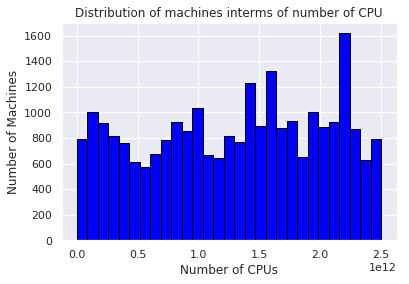

In [290]:
plt.hist(df.toPandas()['timestamp'], color='blue', edgecolor = 'black', bins=int(29))
plt.title('Distribution of machines interms of number of CPU')
plt.xlabel('Number of CPUs')
plt.ylabel('Number of Machines')
plt.show()

In [270]:
cluster1 = df.filter(df.CPU=='1').toPandas()
cluster2 = df.filter(df.CPU=='0.5').toPandas()
cluster3 = df.filter(df.CPU=='0.25').toPandas()

Histogram of CPU aquisition delays


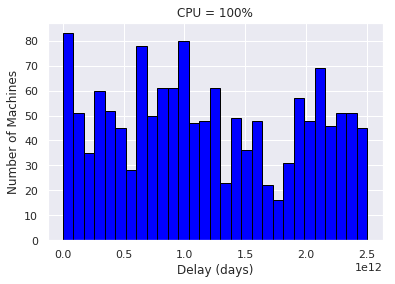

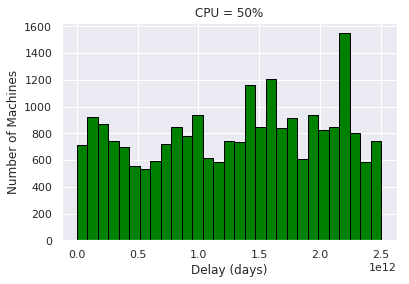

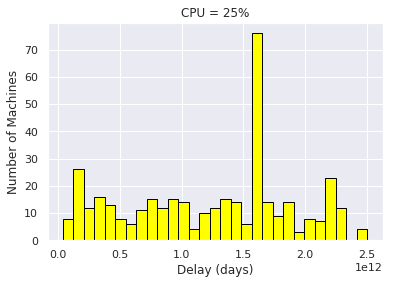

In [288]:
print("Histogram of CPU aquisition delays")
plt.hist(cluster1['timestamp'], color='blue', edgecolor = 'black', bins=int(29), label='CPU 1')
plt.title('CPU = 100%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()
plt.hist(cluster2['timestamp'], color='green', edgecolor = 'black', bins=int(29), label='CPU 0.5')
plt.title('CPU = 50%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()
plt.hist(cluster3['timestamp'], color='yellow', edgecolor = 'black', bins=int(29), label='CPU 0.25')
plt.title('CPU = 25%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()

## Q2: On average, how many tasks compose a job?

Task Events Table
1. timestamp
2. missing info
3. job ID
4. task index - within the job
5. machine ID
6. event type
7. user name
8. scheduling class
9. priority
10. resource request for CPU cores
11. resource request for RAM
12. resource request for local disk space
13. different-machine constraint

In [87]:
task_events = sc.textFile('../../datasets/task_events/part-00000-of-00500.csv.gz')
task_events_RDD = task_events.map(lambda line: line.split(","))
task_events_RDD = task_events_RDD.map(lambda tokens: (tokens[0], tokens[2], tokens[3], tokens[4], tokens[5], tokens[6], tokens[7], tokens[8], tokens[9], tokens[10], tokens[11], tokens[12]))
task_events_RDD = task_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '' and elem[3] !='')

In [155]:
sqlContext = SQLContext(sc)
task_events_df = sqlContext.createDataFrame(task_events_RDD, schema=['timestamp', 'jobID', 'taskID', 'machineID', 'eventType', 'userName', 'schedulingClass', 'priority', 'CPUreq', 'RAMreq', 'diskreq', 'const'])
## get table in a form of [(jobID, list of taskInds)]
job_to_tasks = task_events_df.groupBy('jobID').agg(collect_list('taskID').alias("taskIDs"))
#convert to rdd (jobID, number of tasks)
job_to_tasks_rdd = job_to_tasks.rdd.map(lambda x: list(x)).map(lambda x: (x[0], len(list(set(x[1])))))

number of tasks per job on the average

In [156]:
dupes_rdd.values().sum()/dupes.count()

36.82660381225661

## Q3: What is the percentage of jobs/tasks that got killed or evicted?

1. timestamp
2. missing info
3. job ID
4. event type
5. user name
6. scheduling class
7. job name
8. logical job name

If a task or job that has just EVICTed, FAILed, or KILLed remains runnable, a SUBMIT event
will appear immediately after the descheduling events. (I.e., the system tries to restart jobs
and tasks that have failed.)
This means that a job or task was submitted and immediately scheduled,
or, if the timestamp on the events is 0, that the job or task was submitted and scheduled
before the trace began.

In [158]:
jobs_dir = '../../datasets/job_events/'
list_of_jobs = [os.path.join(jobs_dir, o) for o in os.listdir(jobs_dir) if os.path.splitext(o)[-1].lower()=='.gz']
tasks_dir = '../../datasets/task_events/'
list_of_tasks = [os.path.join(tasks_dir, o) for o in os.listdir(tasks_dir) if os.path.splitext(o)[-1].lower()=='.gz']

In [159]:
job_events = sc.textFile(','.join(list_of_jobs))
job_events_RDD = job_events.map(lambda line: line.split(","))
job_events_RDD = job_events_RDD.map(lambda tokens: (tokens[0], tokens[2], int(tokens[3]), tokens[4], tokens[5], tokens[6], tokens[7]))
job_events_RDD = job_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '')
sqlContext = SQLContext(sc)
job_events_df = sqlContext.createDataFrame(job_events_RDD, schema=['timestamp', 'jobID', 'eventType', 'userName', 'schedulingClass', 'jobName', 'logicalJobName'])

In [25]:
total_jobs = job_events_df.count()
#filter out job events that are neither killed nor evicted
evicted_jobs = job_events_df.where((job_events_df['eventType']==int(2)) | (job_events_df['eventType']==int(5)))
#count the nuber of evicted jobs
evicted_count = evicted_jobs.select('jobID').distinct().count()
evicted_rat = (evicted_count*100)/total_jobs

In [26]:
evicted_rat ##print the percentage of evicted jobs

13.535300426091892

In [203]:
## do the same analysis for tasks
big_tasks_events = sc.textFile(','.join(list_of_tasks))
big_tasks_events_RDD = big_tasks_events.map(lambda line: line.split(","))
big_tasks_events_RDD = big_tasks_events_RDD.map(lambda tokens: (tokens[0], tokens[2], tokens[3], tokens[4], int(tokens[5]), tokens[6], tokens[7], tokens[8], tokens[9], tokens[10], tokens[11], tokens[12]))
big_tasks_events_RDD = big_tasks_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '')
sqlContext = SQLContext(sc)
big_tasks_events_df = sqlContext.createDataFrame(big_tasks_events_RDD, schema=['timestamp', 'jobID', 'taskID', 'machineID', 'eventType', 'userName', 'schedulingClass', 'priority', 'CPUreq', 'RAMrec', 'diskRec', 'const'])

In [31]:
total_tasks = big_tasks_events_df.count()
evicted_tasks = big_tasks_events_df.where((big_tasks_events_df['eventType']==int(2)) | (big_tasks_events_df['eventType']==int(5)))
evicted_tasks_count = evicted_tasks.select('jobID', 'taskID').distinct().count()
evicted_tasks_rat = (evicted_count*100)/total_tasks

In [32]:
evicted_tasks_rat ##print the percentage of evicted tasks

0.18829327589414677

#### Answer: 
        evicted and killed jobs percentage - 13.53 %
        evicted and killed tasks percentage - 0.18 %

## Q4: Do tasks with low priority have a higher probability of being evicted?

In [161]:
task_events_count = task_events_df.count()
s1 = sc.broadcast(task_events_count)

In [163]:
#get the priority of unique evicted tasks
evicted_priority = task_events_df.where(task_events_df['eventType']==int(2)).select('eventType', 'priority')
task_events_count = task_events_df.count()
##map to 1s and count the quantity of each priority
evicted_priority_rdd = evicted_priority.rdd.map(lambda x: (int(x[1]), 1))
evicted_priority_rdd = evicted_priority_rdd.reduceByKey(lambda x, y: x+y)
print(task_events_count, evicted_priority_rdd.count())

330581 5


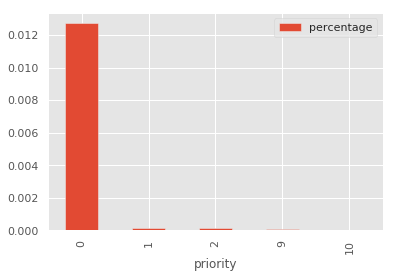

In [224]:
evicted_priority_np = evicted_priority_rdd.map(lambda x: [x[0], (x[1]/task_events_count)]).collect()
d = pd.DataFrame(evicted_priority_np)
d.columns=['priority', 'percentage']
d.sort_values(['priority'], ascending=True).set_index('priority').plot(kind='bar')

In [225]:
evicted_priority_np

[[2, 0.000166373748037546],
 [0, 0.012729104213490794],
 [1, 0.00015729881632640713],
 [9, 6.65494992150184e-05],
 [10, 3.0249772370462914e-06]]

## Q5: Is there a relation between the priority of a task and the amount of resources available on the machine it runs on?

In [176]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

##function to access the resources available on the machine (table machine_events) by machineID
def get_resources(x, p):
    if dict_machine_events_bc.value.get(int(x)) is not None:
        dict_val = dict_machine_events_bc.value.get(int(x))
    else:
        dict_val = (x, str(x), '00.0')
    return (x, dict_val[0], dict_val[1], p)

In [170]:
##costruct a dictionary of machineID and the characteristics of machines
machine_events_dict = machine_events_df.dropDuplicates(['machineID']).select('machineID', 'CPU', 'memory')
machine_events_dict = machine_events_dict.toPandas().set_index('machineID').T.to_dict('list')
##broadcast a dictionary
dict_machine_events_bc = sc.broadcast(machine_events_dict)

In [206]:
task_events_rdd = task_events_df.rdd.map(tuple)
##get machineID and priority of the task from task events table
#resources_rdd = task_events_rdd.map(lambda x: get_resources(x[3], x[7]))
resources_rdd = big_tasks_events_RDD.filter(lambda x: x[3]!='' and x[7]!='').map(lambda x: get_resources(x[3], x[7]))
total = resources_rdd.count()

In [209]:
##filter out these tasks, machineIDs of which does not exist in the machine_events table,
##thus the available resources for which could not be accessed
present_rdd = resources_rdd.filter(lambda x: x[1]!='00.0').map(lambda x: (x[0], float(x[1]), float(x[2]), int(x[3]))) 
print("There are {}% machineIDs missing".format(100*int(total - present_rdd.count())/total))
sqlContext = SQLContext(sc)
present_df = sqlContext.createDataFrame(present_rdd, schema=['machineID', 'CPU', 'memory', 'priority'])\
                .distinct().select('CPU', 'memory', 'priority')

There are 0.0% machineIDs missing


### Construct the Pearson correlation matrix

In [210]:
##Compute the correlation matrix, to see how CPU and memory correlate with priority
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=present_df.columns, outputCol=vector_col)
df_vector = assembler.transform(present_df).select(vector_col)
# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

 ............cpu..........memory.....priority.............................
 cpu..........1............1..........-0.0314909..........................
 memory.......1............1..........-0.0314909..........................
 priority.....-0.0314909...-0.0314909..1..................................      

The matrix bellow means that the correlation coefficients are the following:
    1. priority and CPU - (-0.031) there is no any relationship, the value close to 0
    2. priority and memory - (-0.031) there is no any relationship, the value close to 0
    3. cpu and memory - (1) A perfect uphill (positive) linear relationship, the value close to 0

In [211]:
d = present_df.toPandas()
cpu = d['CPU']
memory = d['memory']
priority = d['priority']

##### 1. CPU and Memory. Strong correlation

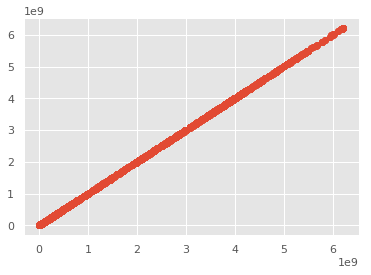

In [212]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.scatter(cpu, memory)
plt.show()

##### 2. CPU and Priority. No correlation

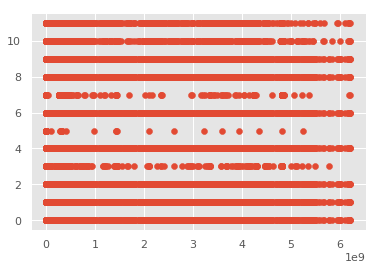

In [213]:
plt.scatter(cpu, priority)
plt.show()

##### 3. Memory and Priority. No correlation

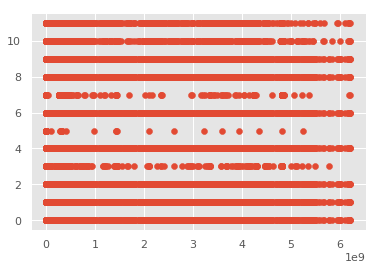

In [214]:
plt.scatter(memory, priority)
plt.show()

## Q6: Are there tasks that consume significantly less resources than what they requested?

1. starttime ofthemeasurementperiod
2. endtime ofthemeasurementperiod
3. jobID
4. taskindex
5. machineID
6. meanCPUusagerate
7. canonicalmemoryusage
8. assignedmemoryusage
9. unmappedpagecachememoryusage 10. total page cache memory usage
11. maximum memory usage
12. mean disk I/O time
13. mean local disk space used
14. maximum CPU usage
15. maximum disk IO time
16. cycles per instruction (CPI)
17. memory accesses per instruction (MAI)
18. sample portion
19. aggregation type (1 if maximums from subcontainers were summed) 

20. sampled CPU usage: mean CPU usage during a random 1s sample in the measurement period  (only in v2.1 and later)




In [14]:
task_usage = sc.textFile('../../datasets/task_usage/part-00000-of-00500.csv')
task_usage_colnames=['starttime', 'endtime', 'jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage', 
                         'assigned_mem', 'unmapped_cache_usage', 'page_cache_usage', 'max_mem_usage', 'disk_io_time', 
                         'max_disk_space', 'max_cpu_usage', 'max_disk_io_time', 'cpi', 'mai', 'sampling_rate', 'agg_type', 'sampled_cpu_usage']

task_usage = task_usage.map(lambda line: line.split(","))
task_usage = task_usage.filter(lambda X: '' not in X)
task_usage = task_usage.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4]), float(tokens[5]), float(tokens[6]), float(tokens[7]), float(tokens[8]), float(tokens[9]), float(tokens[10]), float(tokens[11]), float(tokens[12]), float(tokens[13]), float(tokens[14]), float(tokens[15]), float(tokens[16]), int(tokens[17]), int(tokens[18]), float(tokens[19])))
sqlContext = SQLContext(sc)
task_usage_df = sqlContext.createDataFrame(task_usage, schema=task_usage_colnames)
task_usage_df_1 = task_usage_df.select('jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage').distinct()

In [33]:
task_usage_df_1 = task_usage_df.select('jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage').distinct()
task_events_df_distinct = task_events_df.dropDuplicates(['machineID', 'jobID', 'taskID']).where(col("CPUreq").isNotNull()).where(col("RAMreq").isNotNull())
#if cpu/mem_rat < 1 => we consume less than request

In [93]:
demand = task_events_df_distinct.join(task_usage_df_1, on=['jobID', 'taskID', 'machineID'])

In [94]:
demand = demand.withColumn("cpu_rat", (col('cpu_usage')/col('CPUreq'))).withColumn("ram_rat", (col('mem_usage')/col('RAMreq'))).withColumn("res_rat", ((col('mem_usage')+col('cpu_usage'))/(col('RAMreq')+col('CPUreq'))))\
            .select('jobID', 'taskID', 'machineID', 'CPUreq', 'cpu_usage', 'cpu_rat', 'RAMreq', 'mem_usage', 'ram_rat', 'res_rat')

In [72]:
demand.where(col('res_rat')<1).count()##number of tasks that consume less resources than request

1661028

In [95]:
demand.where(col('res_rat')<0.7).count() ##number of tasks that consume signifficantly less resources than request

1534055

In [73]:
demand.where(col('res_rat')==1).count() ##number of tasks that fully consume the amount of resources they request

25

In [74]:
demand.where(col('res_rat')>1).count() ##number of tasks that consume more resources than request

298993

## Q7: Are there machines for which the resources are largely underused?

In [207]:
machine_events_df_unique = machine_events_df.dropDuplicates(['machineID'])
demand = task_usage_df_1.join(machine_events_df, on=['machineID'])

In [208]:
demand = demand.select('machineID', 'jobID', 'taskID', 'cpu_usage', 'mem_usage', 'CPU', 'memory').withColumn('cpu_used_rat', (100*col('cpu_usage')/col('CPU'))).withColumn('ram_used_rat', (100*col('mem_usage')/col('memory'))).withColumn('res_used_rat', (100*(col('mem_usage')+col('cpu_usage'))/(col('memory')+col('cpu'))))

In [79]:
demand.count()

4014113

In [80]:
hist = demand.select('cpu_used_rat', 'ram_used_rat', 'res_used_rat')

percentage of CPUs being used

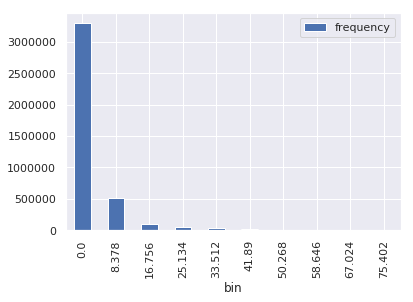

In [84]:
hist_cpu = hist.select('cpu_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_cpu)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

percentage of RAM being used

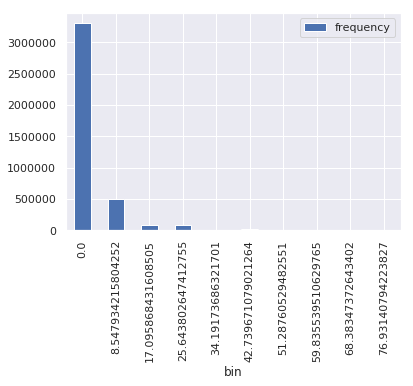

In [85]:
hist_ram = hist.select('ram_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_ram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

percentage of overall resources (ram+cpu) being used

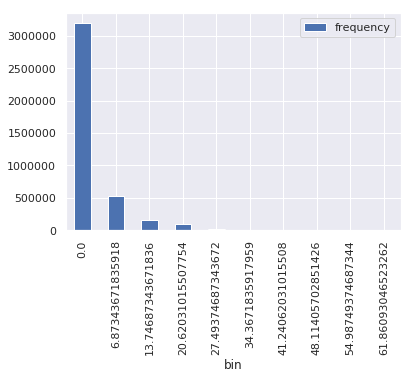

In [86]:
hist_res = hist.select('res_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_res)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

## DataFrame vs RDD

Dataframes are more efficient than RDD, as they are converted into an optimized RDD. Spark optimizes the executions of the operations applied to DataFrames.

RDD - query: group->filter execution: group->filter

DataFrame - query: group->filter execution: filter->group

In [215]:
import time

### RDD

In [216]:
start = time.time()
distinct_count = cpu_all.rdd.map(lambda x: (float(x[0]), 1)).reduceByKey(lambda x, y: x+y).map(lambda x: list([x[0], x[1]])).collect()
end = time.time()
print(end-start)

21.20392084121704


### Data Frame

In [217]:
start = time.time()
distinct_count = cpu_all.groupBy('CPU').count().toPandas()
end = time.time()
print(end-start)

3.559519052505493
